# COGS 118B Final Project - Credit Risk Prediction

Rachel Chen, Chuyi Cui

In this project, we attempted to predict the credit risk of credit card applicants based on their personal information.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Supervised ML Models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

# Clustering Model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Data balancing
from imblearn.over_sampling import SMOTE

# Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, precision_score

## Data Processing

In [27]:
# import dataset
app_df = pd.read_csv('datasets/application_record.csv')
credit_df = pd.read_csv('datasets/credit_record.csv')

# Drop FLAG_MOBIL column since it is a constant
print(app_df['FLAG_MOBIL'].value_counts())
app_df = app_df.drop("FLAG_MOBIL", axis=1)

FLAG_MOBIL
1    438557
Name: count, dtype: int64


In [28]:
app_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0


In [29]:
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


Since this dataset didn't come with labels, we generated credit level label for each applicant based on their credit history. We assigned credit level labels to each applicant based on their credit history. Applicants with no record of being over 30 days overdue were labeled as 'Prime', the rest were labeled as 'Subprime'.

In [30]:
# Data cleaning for labeling
credit_df['STATUS'] = credit_df['STATUS'].replace('X', '-2')
credit_df['STATUS'] = credit_df['STATUS'].replace('C', '-1')
credit_df['STATUS'] = credit_df['STATUS'].astype(int)
credit_df['MONTHS_BALANCE'] = credit_df['MONTHS_BALANCE'].astype(int)

In [31]:
# generate a credit level label for each applicant based on credit history record
def two_classes(client):
    if client['STATUS'].max() <= 0:
        return 'Prime'
    return 'Subprime'

label_df = credit_df.groupby('ID').apply(two_classes).to_frame()
label_df = label_df.rename(columns={0: 'CLASS'})

/var/folders/b9/zn2ysfw94c1_90ggw80svf0m0000gn/T/ipykernel_32921/68061904.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  label_df = credit_df.groupby('ID').apply(two_classes).to_frame()


In [32]:
# concat label to the application dataframe and change index to ID
label_app_df = pd.merge(app_df, label_df, left_on='ID', right_index=True, how='inner')
label_app_df = label_app_df.set_index('ID')

In [33]:
# Encode columns with string labels
str_columns = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", 
            "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "OCCUPATION_TYPE"]
for col in str_columns:
    encoder = LabelEncoder()
    label_app_df[col] = encoder.fit_transform(label_app_df[col])


# Prepare trainning and testing data
X = label_app_df.drop("CLASS", axis=1)
y = label_app_df["CLASS"]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,
5008804,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,0,0,18,2.0
5008805,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,0,0,18,2.0
5008806,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,2.0
5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,0,1,1,14,1.0
5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,0,1,1,14,1.0


## Supervised ML Models

### 1. Random Forest

In [34]:
# Run Random Forest
def run_random_forest(X_train, X_test, y_train, y_test, subprime_weight):
    model = RandomForestClassifier(n_estimators=100, random_state=2, class_weight={'Prime':1, 'Subprime': subprime_weight})
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print("\nRandom Forest:")
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return accuracy, report

rf_accuracy, rf_report = run_random_forest(X_train, X_test, y_train, y_test, 1)


Random Forest:
Accuracy: 0.8841195831047723
Classification Report:
              precision    recall  f1-score   support

       Prime       0.91      0.96      0.94      6425
    Subprime       0.52      0.30      0.38       867

    accuracy                           0.88      7292
   macro avg       0.72      0.63      0.66      7292
weighted avg       0.86      0.88      0.87      7292



### 2. XGBoost Classifier

In [35]:
# Run XGBoost
def run_xgboost(X_train, X_test, y_train, y_test, subprime_weight):

    # Change the label to numerical for XGBoost
    y_train = y_train.map({'Prime': 0, 'Subprime': 1})
    y_test = y_test.map({'Prime': 0, 'Subprime': 1})

    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', max_depth=4, learning_rate=0.1, 
                                       n_estimators=100, random_state=2, scale_pos_weight = subprime_weight)

    xgb_classifier.fit(X_train, y_train)

    y_pred = xgb_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print("\nXGBoost:")
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return accuracy, report

xgb_accuracy, xrb_report = run_xgboost(X_train, X_test, y_train, y_test, 1)


XGBoost:
Accuracy: 0.8813768513439386
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      6425
           1       0.75      0.00      0.01       867

    accuracy                           0.88      7292
   macro avg       0.82      0.50      0.47      7292
weighted avg       0.87      0.88      0.83      7292



### 3. Support Vector Machine (SVM)

In [36]:
# Run SVM
def run_svm(X_train, X_test, y_train, y_test, subprime_weight):

    # Scale X_test and X_train for SVM
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
    X_train_svm = scaling.transform(X_train)
    X_test_svm = scaling.transform(X_test)

    svm = SVC(kernel='rbf', class_weight={'Prime':1, 'Subprime': subprime_weight})  # use 'rbf' for a non-linear kernel
    svm.fit(X_train_svm, y_train)

    y_pred = svm.predict(X_test_svm)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    print("\nSVM:")
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return accuracy, report

svm_accuracy, svm_report = run_svm(X_train, X_test, y_train, y_test, 1)


SVM:
Accuracy: 0.8812397147558969
Classification Report:
              precision    recall  f1-score   support

       Prime       0.88      1.00      0.94      6425
    Subprime       1.00      0.00      0.00       867

    accuracy                           0.88      7292
   macro avg       0.94      0.50      0.47      7292
weighted avg       0.90      0.88      0.83      7292



## Improvement Attemp 1 - Hybrid Modeling with K-Mean Clustering

In [37]:
def run_kmean(X_train, X_test, n_clusters):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  

    kmeans = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = kmeans.fit_predict(X_train_scaled)
    
    # Add cluster labels to the dataset
    X_train_with_clusters = X_train.copy()
    X_train_with_clusters['cluster'] = cluster_labels

    # Fit test data into the clusters
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)  
    test_clusters = kmeans.predict(X_test_scaled) 
    X_test_with_clusters = X_test.copy()
    X_test_with_clusters['cluster'] = test_clusters

    return X_train_with_clusters, X_test_with_clusters


In [38]:
def run_each_cluster(X_train_with_clusters, X_test_with_clusters, y_train, y_test):
    
    rf_reports, xgb_reports, svm_reports = {}, {}, {}
    rf_overall_accuracy, xgb_overall_accuracy, svm_overall_accuracy = 0, 0 ,0
    rf_sp_recall, xgb_sp_recall, svm_sp_recall = 0, 0, 0

    for cluster in sorted(X_train_with_clusters['cluster'].unique()):
        print(f"\nCluster {cluster}:")

        X_train_cluster = X_train_with_clusters[X_train_with_clusters['cluster'] == cluster].drop('cluster', axis=1)
        y_train_cluster = y_train.loc[X_train_with_clusters['cluster'] == cluster]

        X_test_cluster = X_test_with_clusters[X_test_with_clusters['cluster'] == cluster].drop('cluster', axis=1)
        y_test_cluster = y_test.loc[X_test_with_clusters['cluster'] == cluster]

        # run random forest:
        print("\nRun Random Forest:")
        rf_accuracy, rf_report = run_random_forest(X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster, 1)
        rf_reports[cluster] = rf_report
        rf_overall_accuracy += rf_accuracy * X_test_cluster.shape[0]
        rf_sp_recall += rf_report['Subprime']['recall'] * rf_report['Subprime']['support']

        # run XGBoost:
        print("\nRun XGBoost:")
        xgb_accuracy, xgb_report = run_xgboost(X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster, 1)
        xgb_reports[cluster] = xgb_report
        xgb_overall_accuracy += xgb_accuracy * X_test_cluster.shape[0]
        xgb_sp_recall += xgb_report['1']['recall'] * xgb_report['1']['support']

        # run SVM
        print("\nRun SVM:")
        svm_accuracy, svm_report = run_svm(X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster, 1)
        svm_reports[cluster] = svm_report
        svm_overall_accuracy += svm_accuracy * X_test_cluster.shape[0]
        svm_sp_recall += svm_report['Subprime']['recall'] * svm_report['Subprime']['support']

    # print overall accuracy and recall rate for subprime
    test_size = X_test_with_clusters.shape[0]
    subprime_size = y_test.value_counts()['Subprime']

    print("Overall Random Forest Accuracy:", rf_overall_accuracy/test_size,
          ", Overall Recall Rate of Subprime:", rf_sp_recall/subprime_size)
    print("Overall XGBoost Accuracy:", xgb_overall_accuracy/test_size,
          ", Overall Recall Rate of Subprime:", xgb_sp_recall/subprime_size)
    print("Overall SVM Accuracy:", svm_overall_accuracy/test_size,
          ", Overall Recall Rate of Subprime:", svm_sp_recall/subprime_size)

    return rf_reports, xgb_reports, svm_reports


In [39]:
# run k-mean
X_train_with_clusters, X_test_with_clusters = run_kmean(X_train.copy(), X_test.copy(), n_clusters=4)
rf_reports, xgb_reports, svm_reports = run_each_cluster(X_train_with_clusters, X_test_with_clusters, y_train, y_test)


Cluster 0:

Run Random Forest:

Random Forest:
Accuracy: 0.9044056525353283
Classification Report:
              precision    recall  f1-score   support

       Prime       0.94      0.96      0.95      1093
    Subprime       0.47      0.35      0.40       110

    accuracy                           0.90      1203
   macro avg       0.70      0.66      0.68      1203
weighted avg       0.89      0.90      0.90      1203


Run XGBoost:

XGBoost:
Accuracy: 0.9093931837073982
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1093
           1       1.00      0.01      0.02       110

    accuracy                           0.91      1203
   macro avg       0.95      0.50      0.49      1203
weighted avg       0.92      0.91      0.87      1203


Run SVM:


/opt/anaconda3/envs/cogs118b/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cogs118b/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cogs118b/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu


SVM:
Accuracy: 0.9085619285120532
Classification Report:
              precision    recall  f1-score   support

       Prime       0.91      1.00      0.95      1093
    Subprime       0.00      0.00      0.00       110

    accuracy                           0.91      1203
   macro avg       0.45      0.50      0.48      1203
weighted avg       0.83      0.91      0.87      1203


Cluster 1:

Run Random Forest:

Random Forest:
Accuracy: 0.8751004016064257
Classification Report:
              precision    recall  f1-score   support

       Prime       0.90      0.96      0.93      2180
    Subprime       0.50      0.25      0.34       310

    accuracy                           0.88      2490
   macro avg       0.70      0.61      0.63      2490
weighted avg       0.85      0.88      0.86      2490


Run XGBoost:

XGBoost:
Accuracy: 0.8775100401606426
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      2180
   

/opt/anaconda3/envs/cogs118b/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cogs118b/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cogs118b/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu


SVM:
Accuracy: 0.8746177370030581
Classification Report:
              precision    recall  f1-score   support

       Prime       0.87      1.00      0.93      1430
    Subprime       0.00      0.00      0.00       205

    accuracy                           0.87      1635
   macro avg       0.44      0.50      0.47      1635
weighted avg       0.76      0.87      0.82      1635


Cluster 3:

Run Random Forest:

Random Forest:
Accuracy: 0.8823828920570265
Classification Report:
              precision    recall  f1-score   support

       Prime       0.91      0.96      0.93      1722
    Subprime       0.54      0.31      0.39       242

    accuracy                           0.88      1964
   macro avg       0.72      0.63      0.66      1964
weighted avg       0.86      0.88      0.87      1964


Run XGBoost:

XGBoost:
Accuracy: 0.8767820773930753
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1722
   

## Improvement Attemp 2 - Synthetic Minority Oversampling Technique (SMOTE)

CLASS
Prime       32166
Subprime     4291
Name: count, dtype: int64


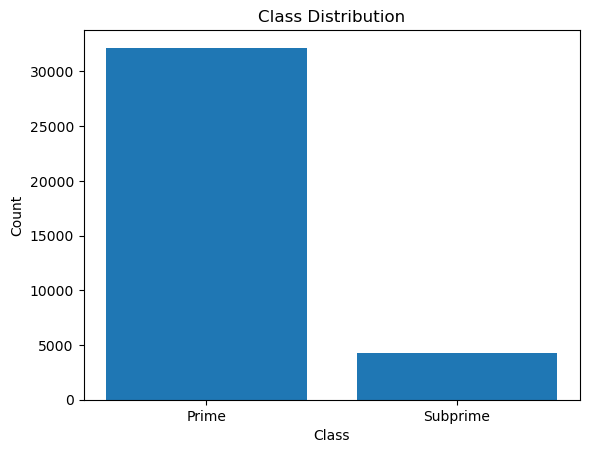

In [40]:
print(label_app_df['CLASS'].value_counts())
class_counts = y.value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [41]:
smote = SMOTE(random_state=2)
X_train_with_smote, y_train_with_smote = smote.fit_resample(X_train, y_train)

# run random forest with smote
print("\nRun Random Forest:")
rf_smote_accuracy, rf_smote_report = run_random_forest(X_train_with_smote, X_test, y_train_with_smote, y_test, 1)

# run XGBoost with smote
print("\nRun XGBoost:")
xgb_smote_accuracy, xrb_smote_report = run_xgboost(X_train, X_test, y_train, y_test, 1)

# run svm with smote
print("\nRun SVM:")
svm_smote_accuracy, svm_smote_report = run_svm(X_train_with_smote, X_test, y_train_with_smote, y_test, 1)


Run Random Forest:

Random Forest:
Accuracy: 0.8610806363137685
Classification Report:
              precision    recall  f1-score   support

       Prime       0.92      0.92      0.92      6425
    Subprime       0.42      0.42      0.42       867

    accuracy                           0.86      7292
   macro avg       0.67      0.67      0.67      7292
weighted avg       0.86      0.86      0.86      7292


Run XGBoost:

XGBoost:
Accuracy: 0.8813768513439386
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      6425
           1       0.75      0.00      0.01       867

    accuracy                           0.88      7292
   macro avg       0.82      0.50      0.47      7292
weighted avg       0.87      0.88      0.83      7292


Run SVM:

SVM:
Accuracy: 0.7253154141524959
Classification Report:
              precision    recall  f1-score   support

       Prime       0.89      0.78      0.83      6425
    S

## Improvement Attemp 3 - Imbalanced Class Weights

Use grid search to find the best class weight for 'Subprime'

In [42]:
# Define the random forest model
model = RandomForestClassifier(random_state=2)

# Define the grid of class weights
param_grid = {'class_weight': [{'Prime': 1, 'Subprime': w} for w in [1, 5, 10, 20, 50]]}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring={
        'recall': make_scorer(recall_score, pos_label='Subprime'),
        'precision': make_scorer(precision_score, average='binary', pos_label='Subprime')
    },
    refit='recall', 
    cv=5
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best class weight:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best class weight: {'class_weight': {'Prime': 1, 'Subprime': 50}}
Best score: 0.5549092926964614


In [43]:
 #Manually compare the performance of random forest with different class weights of 'Subprime'
rf_accuracy_1, rf_report_1 = run_random_forest(X_train, X_test, y_train, y_test, 1)
rf_accuracy_5, rf_report_5 = run_random_forest(X_train, X_test, y_train, y_test, 5)
rf_accuracy_8, rf_report_8 = run_random_forest(X_train, X_test, y_train, y_test, 8)
rf_accuracy_20, rf_report_20 = run_random_forest(X_train, X_test, y_train, y_test, 20)



Random Forest:
Accuracy: 0.8841195831047723
Classification Report:
              precision    recall  f1-score   support

       Prime       0.91      0.96      0.94      6425
    Subprime       0.52      0.30      0.38       867

    accuracy                           0.88      7292
   macro avg       0.72      0.63      0.66      7292
weighted avg       0.86      0.88      0.87      7292


Random Forest:
Accuracy: 0.8513439385628085
Classification Report:
              precision    recall  f1-score   support

       Prime       0.93      0.90      0.91      6425
    Subprime       0.40      0.48      0.44       867

    accuracy                           0.85      7292
   macro avg       0.66      0.69      0.68      7292
weighted avg       0.87      0.85      0.86      7292


Random Forest:
Accuracy: 0.8359846407021393
Classification Report:
              precision    recall  f1-score   support

       Prime       0.93      0.88      0.90      6425
    Subprime       0.37      0.51

In [44]:
# XGBoost
xgb_accuracy_1, xgb_report_1 = run_xgboost(X_train, X_test, y_train, y_test, 1)
xgb_accuracy_5, xgb_report_5 = run_xgboost(X_train, X_test, y_train, y_test, 5)
xgb_accuracy_10, xgb_report_7 = run_xgboost(X_train, X_test, y_train, y_test, 7)
xgb_accuracy_20, xgb_report_9 = run_xgboost(X_train, X_test, y_train, y_test, 9)


XGBoost:
Accuracy: 0.8813768513439386
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      6425
           1       0.75      0.00      0.01       867

    accuracy                           0.88      7292
   macro avg       0.82      0.50      0.47      7292
weighted avg       0.87      0.88      0.83      7292


XGBoost:
Accuracy: 0.8614920460778935
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      6425
           1       0.31      0.14      0.19       867

    accuracy                           0.86      7292
   macro avg       0.60      0.55      0.56      7292
weighted avg       0.82      0.86      0.84      7292


XGBoost:
Accuracy: 0.7113274821722435
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      6425
           1       0.19      0.44      0.27       8

In [45]:
# SVM
svm_accuracy_1, svm_report_1 = run_svm(X_train, X_test, y_train, y_test, 1)
svm_accuracy_5, svm_report_5 = run_svm(X_train, X_test, y_train, y_test, 4)
svm_accuracy_7, svm_report_7 = run_svm(X_train, X_test, y_train, y_test, 6)
svm_accuracy_9, svm_report_9 = run_svm(X_train, X_test, y_train, y_test, 8)


SVM:
Accuracy: 0.8812397147558969
Classification Report:
              precision    recall  f1-score   support

       Prime       0.88      1.00      0.94      6425
    Subprime       1.00      0.00      0.00       867

    accuracy                           0.88      7292
   macro avg       0.94      0.50      0.47      7292
weighted avg       0.90      0.88      0.83      7292


SVM:
Accuracy: 0.8701316511245201
Classification Report:
              precision    recall  f1-score   support

       Prime       0.89      0.98      0.93      6425
    Subprime       0.28      0.06      0.10       867

    accuracy                           0.87      7292
   macro avg       0.58      0.52      0.51      7292
weighted avg       0.81      0.87      0.83      7292


SVM:
Accuracy: 0.7837356006582556
Classification Report:
              precision    recall  f1-score   support

       Prime       0.90      0.85      0.87      6425
    Subprime       0.19      0.26      0.22       867

    accu

## Visualization

Accuracy: 0.8359846407021393
Classification Report:
              precision    recall  f1-score   support

       Prime       0.93      0.88      0.90      6425
    Subprime       0.37      0.51      0.43       867

    accuracy                           0.84      7292
   macro avg       0.65      0.70      0.67      7292
weighted avg       0.86      0.84      0.85      7292



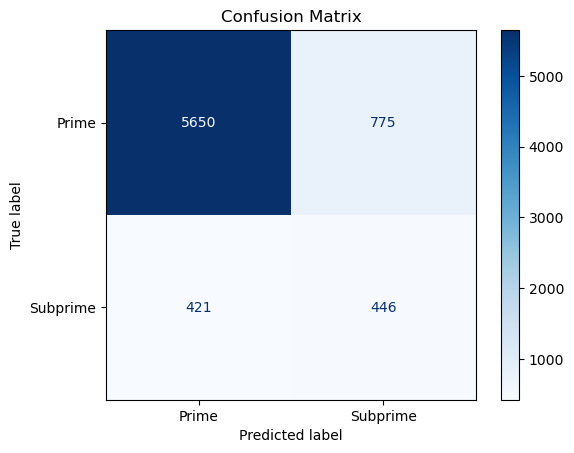

In [46]:
model = RandomForestClassifier(n_estimators=100, random_state=2, class_weight={'Prime':1, 'Subprime': 8})
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

labels = sorted(label_app_df['CLASS'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()